In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from models.MLP import MLP

In [2]:
hidden_dim = 64
output_dim = 1
learning_rate = 0.00005
num_epochs = 3000
epochs_step = 10
batch_size = 32
test_size=0.3
dropout_rate = 0.5
pos_weight_ratio = 100
ds_name = '20220328-or-eng-full.csv'
train = True

In [3]:
data = pd.read_csv(ds_name)

# removed_cols = ['Postoperative Olanzapine', 'Postoperative Fluphenazine', 'Postoperative Flupentixol']
# data = data.drop(removed_cols, axis=1)

# 将特征和目标分开
features = data.drop('Label', axis=1).values
target = data['Label'].values

print(features.shape)
print(target.shape)

(1809, 101)
(1809,)


In [4]:
# 划分训练集和测试集
train_features, test_features, train_target, test_target = train_test_split(
    features, target, test_size=test_size, random_state=42)

In [5]:
# 将数据转换为PyTorch张量
train_features = torch.Tensor(train_features)
test_features = torch.Tensor(test_features)
train_target = torch.tensor(train_target, dtype=torch.float32).view(-1, 1)
test_target = torch.tensor(test_target, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(train_features, train_target)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

input_dim = train_features.shape[1]

In [6]:
model = MLP(input_dim, hidden_dim, output_dim, dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

pos_weight = torch.tensor(
    len(train_target) / (2 * torch.sum(train_target)), dtype=torch.float32)
print(pos_weight)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight*30)

# To device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

train_features = train_features.to(device)
test_features = test_features.to(device)
train_target = train_target.to(device)
test_target = test_target.to(device)

# Compile model
model = torch.compile(model)

tensor(12.6600)


/tmp/ipykernel_26460/1471406686.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor(
/home/tosaki/miniconda3/envs/torch201/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def train_model(model, criterion, optimizer, num_epochs=100):
    train_losses = []
    test_accs = []
    for epoch in tqdm(range(num_epochs)):
        model.train()

        if epoch == 750:
            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight*pos_weight_ratio)
            criterion = criterion.to(device)

        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            # To device
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()


        # save model
        if (epoch + 1) % epochs_step == 0:
            # test
            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            model.eval()
            outputs = model(test_features)
            outputs = outputs > 0.5
            acc = torch.sum(outputs == test_target).item() / len(test_target)
            test_accs.append(acc)
            
            torch.save(model.state_dict(),
                       'pths/MLP-{:04}-{:02.4f}.pth'.format(epoch + 1, acc*100))
    return train_losses, test_accs

Number of positive samples: 50
Number of negative samples: 1216


  0%|          | 0/3000 [00:00<?, ?it/s]/home/tosaki/miniconda3/envs/torch201/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:90: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
100%|██████████| 3000/3000 [04:41<00:00, 10.67it/s]


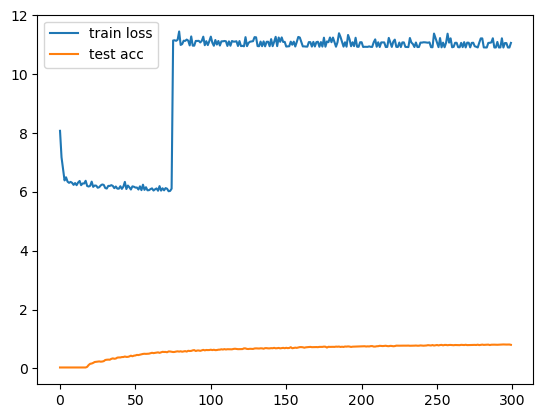

In [8]:
if train == True:
    # torch._dynamo.config.suppress_errors = True

    # Count number of positive and negative samples
    print('Number of positive samples: {}'.format((train_target == 1).sum()))
    print('Number of negative samples: {}'.format((train_target == 0).sum()))

    train_losses, test_accs = train_model(model, criterion, optimizer, num_epochs=num_epochs)

    # Plot losses
    plt.plot(train_losses, label='train loss')
    plt.plot(test_accs, label='test acc')
    plt.legend()
    plt.show()

    torch.save(model.state_dict(), 'pths/MLP-final.pth')

In [9]:
def test_model(model, features, target):
    # Test in all data
    model.eval()
    outputs = model(features)
    outputs = outputs > 0.5

    # Reshape
    outputs = outputs.view(-1)
    target = target.view(-1)
    success = torch.sum(outputs == target).item()
    print('Success: {}/{}'.format(success, len(target)))

    acc = success / len(target)
    print('Accuracy: {:.2f}'.format(acc))

    # Confusion matrix
    TP = torch.sum((outputs == 1) & (target == 1)).item()
    TN = torch.sum((outputs == 0) & (target == 0)).item()
    FP = torch.sum((outputs == 1) & (target == 0)).item()
    FN = torch.sum((outputs == 0) & (target == 1)).item()

    print('TP: {}, TN: {}, FP: {}, FN: {}'.format(TP, TN, FP, FN))

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    print('Sensitivity: {:.2f}, Specificity: {:.2f}'.format(sensitivity, specificity))

In [10]:
# Load model
# model.load_state_dict(torch.load('pths/MLP-500-9.5580e-01.pth'))

print('In test set:')
test_model(model, test_features, test_target)

print('\nIn all data:')
test_model(model, torch.Tensor(features).to(device), torch.Tensor(target).to(device))

In test set:
Success: 436/543
Accuracy: 0.80
TP: 13, TN: 423, FP: 102, FN: 5
Sensitivity: 0.72, Specificity: 0.81
In all data:
Success: 1469/1809
Accuracy: 0.81
TP: 63, TN: 1406, FP: 335, FN: 5
Sensitivity: 0.93, Specificity: 0.81
